# Strategy Optimization with Smoothing (the optimal frequency)

## Getting started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Version 3.0 (advanced Performance Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().ffill() 
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | {}: {}".format(window, self.metric, round(perf, 6))) 
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | {} vs Windows".format(self.metric), fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("{}".format(self.metric), fontsize = 15) 
            plt.show()   
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | WINDOW = {}".format(self.symbol, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [3]:
low_f = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
low_f

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [4]:
high_f = pd.read_csv("one_minute.csv", parse_dates = ["time"], index_col = "time")
high_f

,EURUSD,GBPUSD,EURAUD
time,,,
2018-01-01 22:00:00,1.20071,1.35021,1.53836
2018-01-01 22:01:00,1.20068,1.35105,1.53829
2018-01-01 22:02:00,1.20073,1.35028,1.53834
2018-01-01 22:03:00,1.20072,1.35135,1.53833
2018-01-01 22:04:00,NaN,1.35098,NaN
...,...,...,...
2019-12-30 23:56:00,NaN,1.31136,1.59978
2019-12-30 23:57:00,1.12018,1.31126,1.60000
2019-12-30 23:58:00,NaN,1.31122,1.59994


In [5]:
high_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737544 entries, 2018-01-01 22:00:00 to 2019-12-31 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EURUSD  693492 non-null  float64
 1   GBPUSD  686852 non-null  float64
 2   EURAUD  710540 non-null  float64
dtypes: float64(3)
memory usage: 22.5 MB


In [ ]:
# high_f.fillna(method = "ffill", inplace = True) # old

In [6]:
high_f.ffill(inplace = True) # NEW

In [7]:
high_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737544 entries, 2018-01-01 22:00:00 to 2019-12-31 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EURUSD  737544 non-null  float64
 1   GBPUSD  737544 non-null  float64
 2   EURAUD  737544 non-null  float64
dtypes: float64(3)
memory usage: 22.5 MB


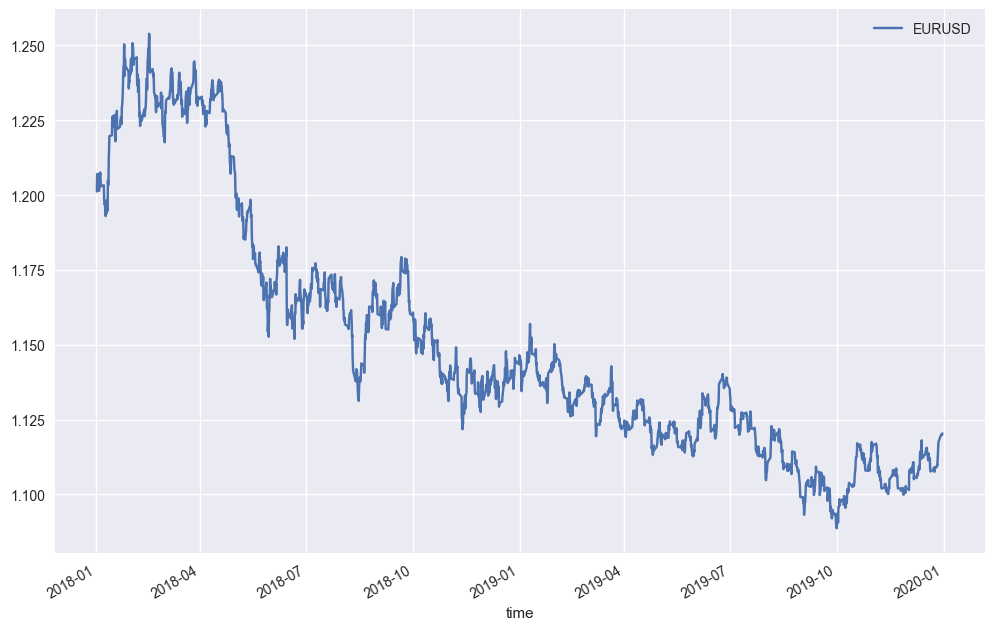

In [8]:
low_f.plot(figsize = (12, 8))
plt.show()

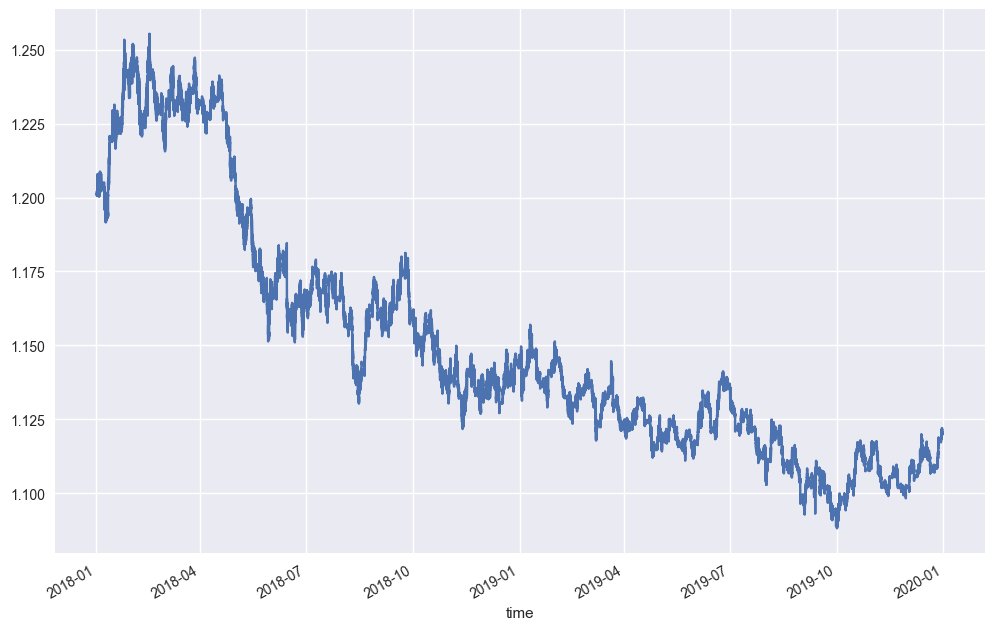

In [9]:
high_f.EURUSD.plot(figsize = (12, 8))
plt.show()

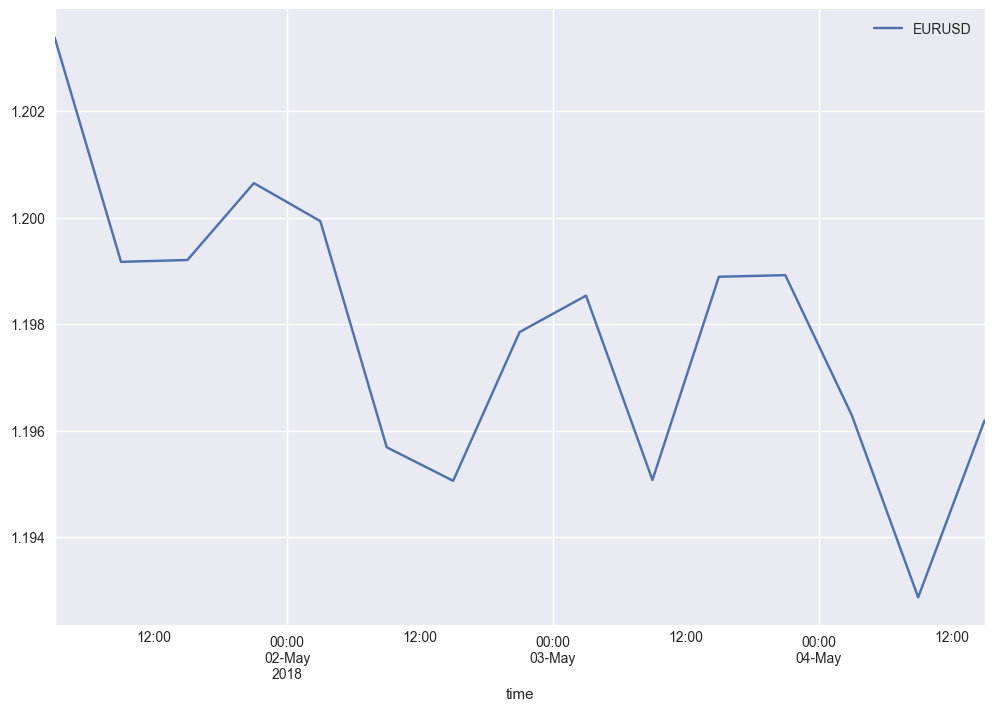

In [10]:
low_f.loc["2018-05-01":"2018-05-05"].plot(figsize = (12, 8))
plt.show()

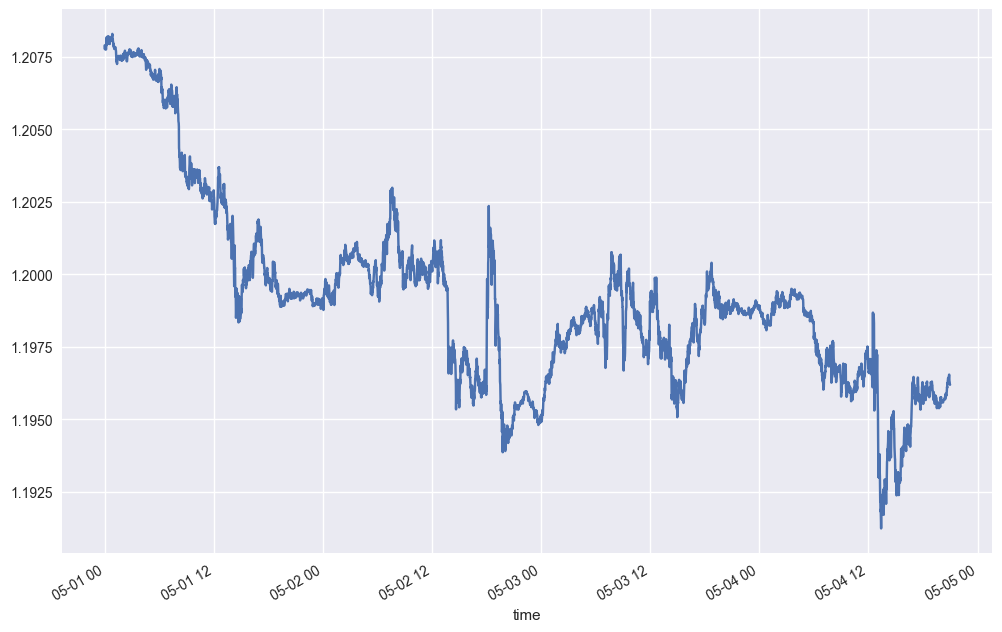

In [11]:
high_f.loc["2018-05-01":"2018-05-05", "EURUSD"].plot(figsize = (12, 8))
plt.show()

__Conclusion and open Questions:__
- 1 minute data contains __additional short-term price moves__ and __volatility__.
- __Price Volatility__ is a __desirable attribute__ for trading. We can´t make profits if prices don´t move.  
- __More information is better__ than less information.
- Can we __take advantage__ of the short-term volatility or is it just (patternless) __random noise__? 
- At least it __doesn´t hurt__ us, right? 
- Best Contrarian Strategy based on __1 minute data__ should be __at least as good__ as the best one based on __6h data__?

## How Trading Strategies are impacted by Random Noise (Part 1)

__Initial Assumption: Zero Trading Costs__

In [12]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0

__6h Data__

In [13]:
tester1 = ConBacktester(filepath = "intraday.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester1

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [14]:
tester1.optimize_strategy((1, 1001, 1), metric = "Multiple")

Windows: 44 | Multiple: 1.288223
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 44
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.288223
Multiple (Buy-and-Hold):     0.913293
--------------------------------------
Out-/Underperformance:       0.37493


CAGR:                        0.13874
Annualized Mean:             0.12989
Annualized Std:              0.060266
Sharpe Ratio:                2.155286
Sortino Ratio:               3.346279
Maximum Drawdown:            0.057729
Calmar Ratio:                2.403288
Max Drawdown Duration:       81 Days
Kelly Criterion:             36.226556


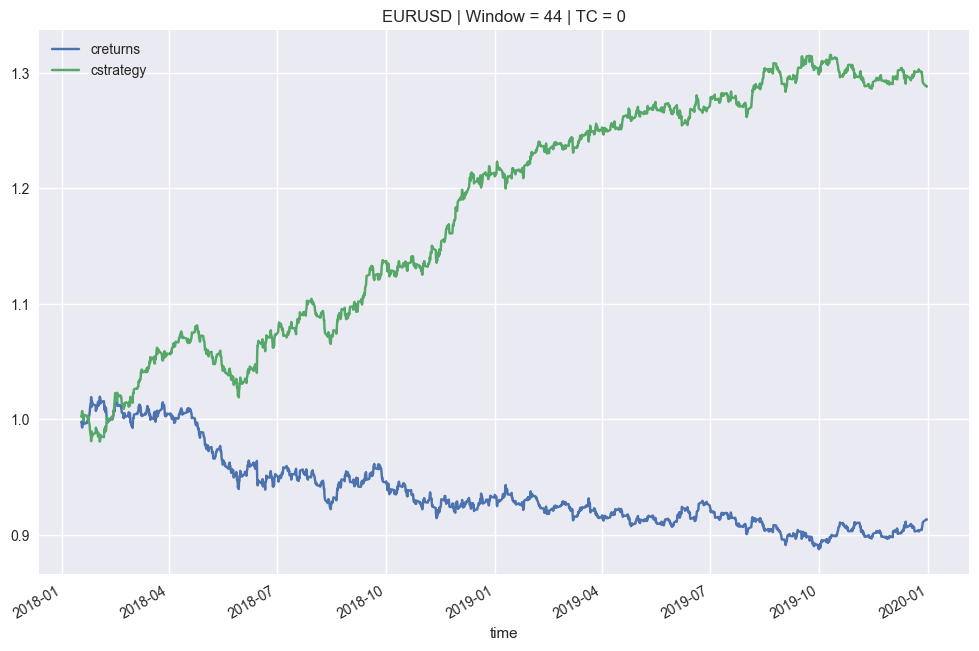

In [15]:
tester1.plot_results()

__Summary__:

- Bar length (Frequency/Granularity): __6 hours__
- Decision/Trading Frequency: __6 hours__
- Decisions based on the performance of the most recent __264 hours__ (44 * 6h)

__1 minute Data__

In [16]:
tester2 = ConBacktester(filepath = "one_minute.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester2

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

__Plan: Re-Engineering the windows = 44 Strategy (6h) with 1 minute Data.__

In [17]:
window = 44
hours = 6
minutes = 60

In [18]:
tester2.test_strategy(window = window * hours * minutes)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 15840
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.304608
Multiple (Buy-and-Hold):     0.913462
--------------------------------------
Out-/Underperformance:       0.391146


CAGR:                        0.145928
Annualized Mean:             0.136336
Annualized Std:              0.067859
Sharpe Ratio:                2.009107
Sortino Ratio:               2.852712
Maximum Drawdown:            0.059655
Calmar Ratio:                2.446184
Max Drawdown Duration:       105 Days
Kelly Criterion:             30.10717


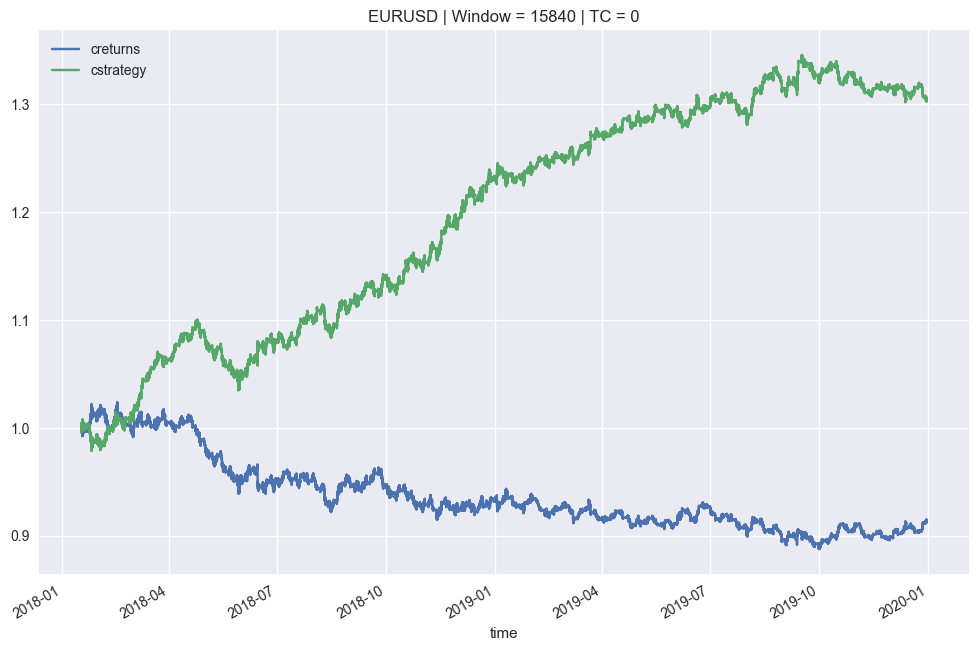

In [19]:
tester2.plot_results()

__Summary__:

- Bar length (Frequency/Granularity): __1 minute__
- Decision/Trading Frequency: __1 minute__
- Decisions based on the performance of the most recent __264 hours__ (15,840 minutes)

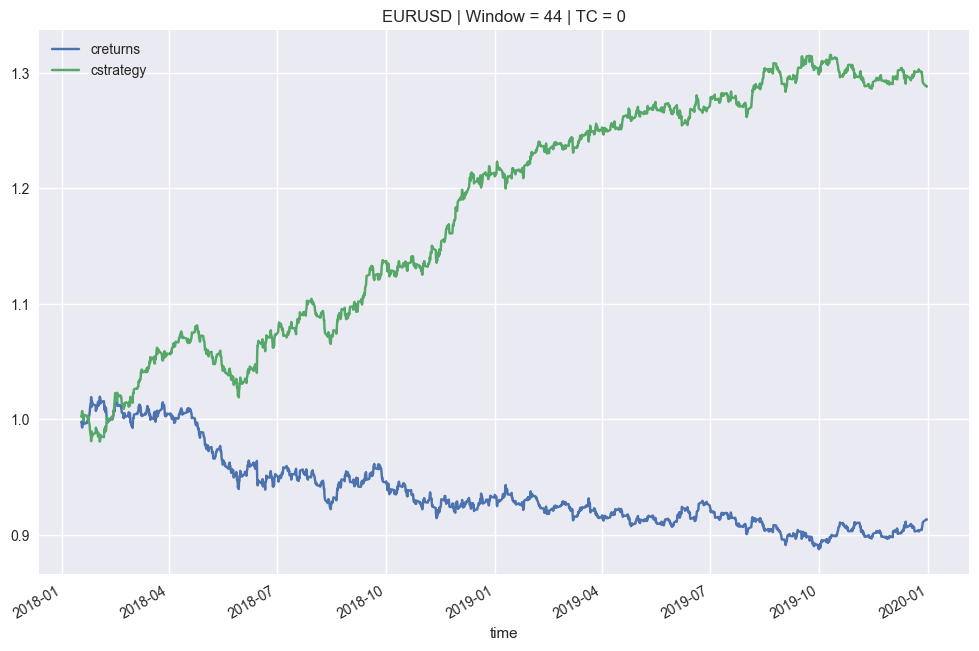

In [20]:
tester1.plot_results()

__Conclusion:__
- Can we take advantage of the short-term volatility or is it just (patternless) random noise? __A: (Small) benefit__
- At least it doesn´t hurt us, right? __A: Correct__
- Best Contrarian Strategy based on 1 minute data should be at least as good as the best one based on 6h data? __A: Correct__

__Be careful, so far we ignored trading costs__!

## How Trading Strategies are impacted by Random Noise (Part 2)

__Now with Trading Costs:__

In [21]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

__6h Data__

In [22]:
tester1 = ConBacktester(filepath = "intraday.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester1

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [23]:
tester1.optimize_strategy((1, 1001, 1), metric = "Multiple")

Windows: 51 | Multiple: 1.262038
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 51
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.262038
Multiple (Buy-and-Hold):     0.915401
--------------------------------------
Out-/Underperformance:       0.346637


CAGR:                        0.126996
Annualized Mean:             0.119772
Annualized Std:              0.059895
Sharpe Ratio:                1.999706
Sortino Ratio:               3.099553
Maximum Drawdown:            0.060965
Calmar Ratio:                2.083103
Max Drawdown Duration:       93 Days
Kelly Criterion:             33.85233


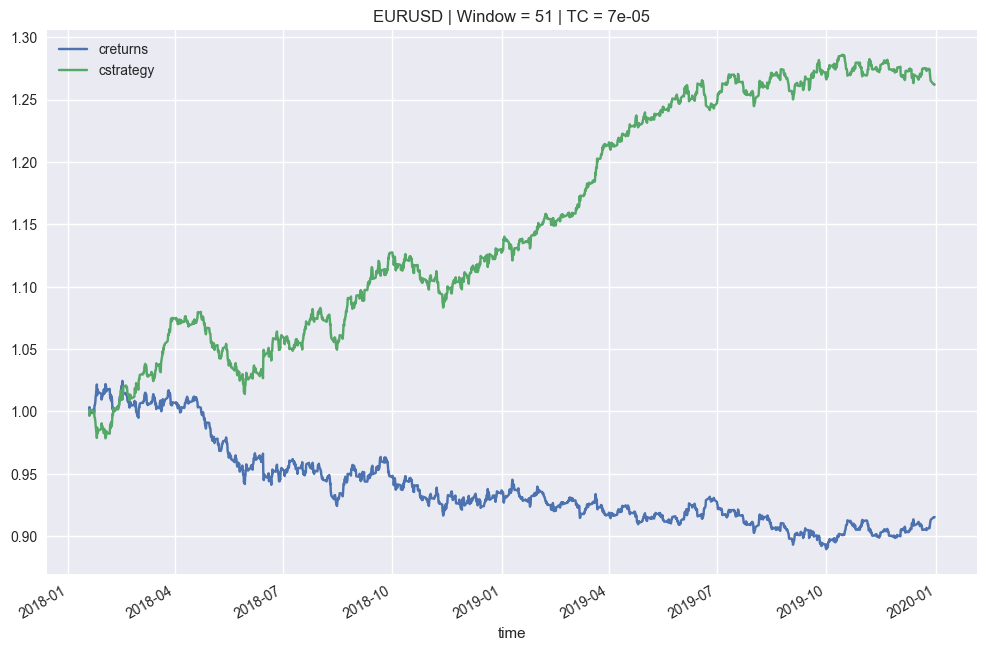

In [24]:
tester1.plot_results()

__1 minute Data__

In [25]:
tester2 = ConBacktester(filepath = "one_minute.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester2

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

__Plan: Re-Engineering the windows = 51 Strategy (6h) with 1 minute Data.__

In [26]:
window = 51
hours = 6
minutes = 60

In [27]:
tester2.test_strategy(window * hours * minutes)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 18360
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.866034
Multiple (Buy-and-Hold):     0.914767
--------------------------------------
Out-/Underperformance:       -0.048733


CAGR:                        -0.071224
Annualized Mean:             -0.074005
Annualized Std:              0.06759
Sharpe Ratio:                -1.094901
Sortino Ratio:               -1.549118
Maximum Drawdown:            0.164531
Calmar Ratio:                -0.43289
Max Drawdown Duration:       635 Days
Kelly Criterion:             -15.699168


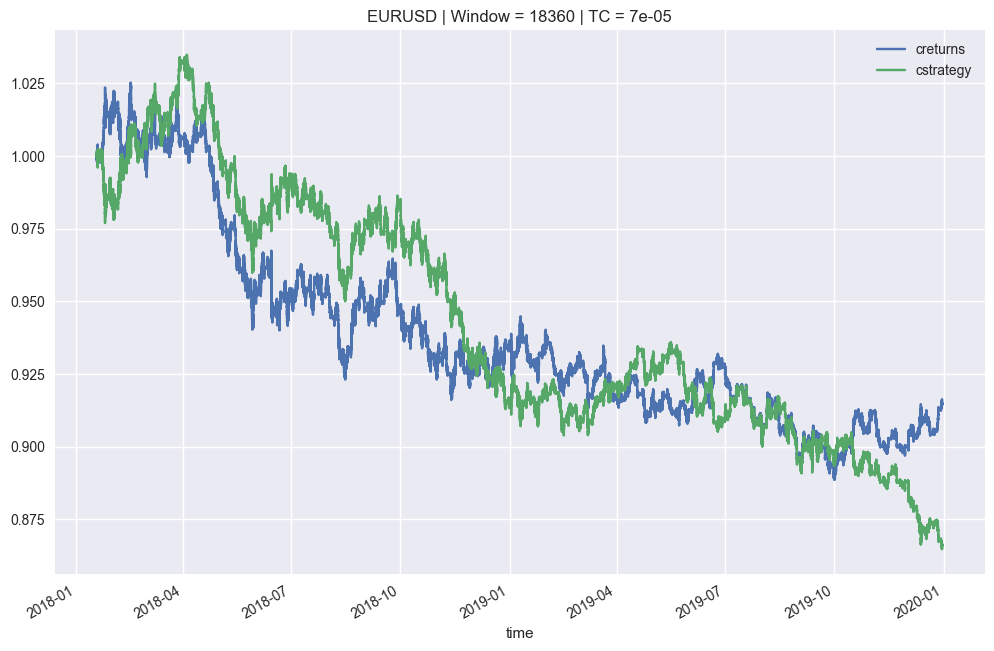

In [28]:
tester2.plot_results()

__Why is that?__

- 1 minute Data (unsmoothed) has lots of __random noise__ (false/unprofitable trading signals) 
- leading to __excessive (and useless) trading__
- __additional trading costs are way higher__ than the additional (small) benefits.

In [29]:
tester1.results.trades.value_counts()

trades
0.0    1876
2.0     142
Name: count, dtype: int64

In [30]:
tester2.results.trades.value_counts() # trading increases by a factor of 20!!!

trades
0.0    716367
2.0      2816
Name: count, dtype: int64

In [31]:
tester2.optimize_strategy((1*60*6, 1001*60*6, 1*60*6)) # try to find optimal strategy based on 1 minute data

Windows: 232200 | Multiple: 1.00127
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 232200
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.00127
Multiple (Buy-and-Hold):     0.990705
--------------------------------------
Out-/Underperformance:       0.010565


CAGR:                        0.000924
Annualized Mean:             0.000929
Annualized Std:              0.061302
Sharpe Ratio:                0.015157
Sortino Ratio:               0.021505
Maximum Drawdown:            0.071229
Calmar Ratio:                0.012968
Max Drawdown Duration:       462 Days
Kelly Criterion:             0.74724


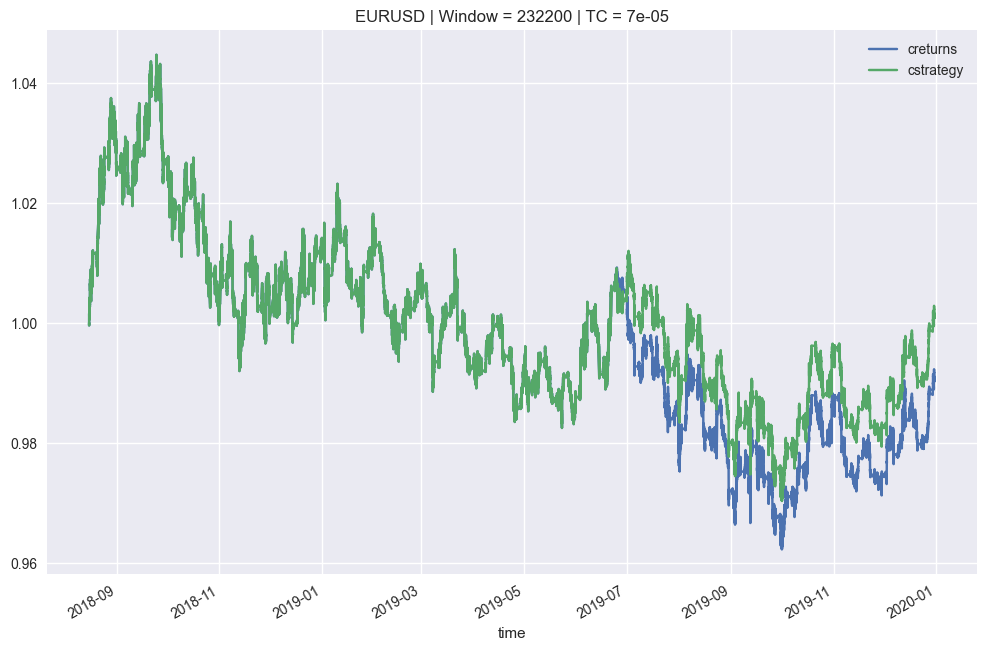

In [32]:
tester2.plot_results()

__Conclusion:__
- there is __no chance to find (highly) profitable simple contrarian strategies with 1 minute data__.
- __Short term volatility__ is just (patternless) __random noise__ -> at least for the simple contrarian strategy
- __wrong__: the higher the data frequency the better for trading (more information is better than less) 
- there must be an __optimal frequency/granularity__ for the simple contrarian strategy and the given trading cost level

## Data Resampling/Smoothing and Backtesting

__Plan: Backtesting the (random) strategy with frequency = 180 minutes | window = 100__

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [34]:
symbol = "EURUSD"

__Get Data__

In [35]:
data = pd.read_csv("one_minute.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD,GBPUSD,EURAUD
time,,,
2018-01-01 22:00:00,1.20071,1.35021,1.53836
2018-01-01 22:01:00,1.20068,1.35105,1.53829
2018-01-01 22:02:00,1.20073,1.35028,1.53834
2018-01-01 22:03:00,1.20072,1.35135,1.53833
2018-01-01 22:04:00,NaN,1.35098,NaN
...,...,...,...
2019-12-30 23:56:00,NaN,1.31136,1.59978
2019-12-30 23:57:00,1.12018,1.31126,1.60000
2019-12-30 23:58:00,NaN,1.31122,1.59994


In [36]:
data = data[symbol].to_frame().ffill() # NEW
data

,EURUSD
time,
2018-01-01 22:00:00,1.20071
2018-01-01 22:01:00,1.20068
2018-01-01 22:02:00,1.20073
2018-01-01 22:03:00,1.20072
2018-01-01 22:04:00,1.20072
...,...
2019-12-30 23:56:00,1.12018
2019-12-30 23:57:00,1.12018
2019-12-30 23:58:00,1.12018


In [37]:
data.rename(columns = {symbol:"price"}, inplace = True)

In [38]:
data

,price
time,
2018-01-01 22:00:00,1.20071
2018-01-01 22:01:00,1.20068
2018-01-01 22:02:00,1.20073
2018-01-01 22:03:00,1.20072
2018-01-01 22:04:00,1.20072
...,...
2019-12-30 23:56:00,1.12018
2019-12-30 23:57:00,1.12018
2019-12-30 23:58:00,1.12018


In [39]:
data["returns"] = np.log(data.price / data.price.shift(1))
data

,price,returns
time,,
2018-01-01 22:00:00,1.20071,NaN
2018-01-01 22:01:00,1.20068,-0.000025
2018-01-01 22:02:00,1.20073,0.000042
2018-01-01 22:03:00,1.20072,-0.000008
2018-01-01 22:04:00,1.20072,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


__Prepare Data__

In [40]:
freq = 180
freq = "{}min".format(freq)
window = 100

In [41]:
freq

'180min'

In [42]:
resamp = data.price.to_frame().resample(freq).last().dropna().iloc[:-1]
resamp

,price
time,
2018-01-01 21:00:00,1.20108
2018-01-02 00:00:00,1.20096
2018-01-02 03:00:00,1.20245
2018-01-02 06:00:00,1.20450
2018-01-02 09:00:00,1.20594
...,...
2019-12-30 09:00:00,1.11916
2019-12-30 12:00:00,1.12058
2019-12-30 15:00:00,1.12107


- use last() to get a bar´s close price
- dropna() removes NaNs on weekends and bank holidays (resample() creates ALL 180m bars)
- the last bar is typically incomplete -> iloc[:-1]
- Index: It´s the starting time (open) of the bars

In [43]:
resamp["returns"] = np.log(resamp / resamp.shift(1))
resamp["roll_return"] = resamp["returns"].rolling(window).mean()
resamp

,price,returns,roll_return
time,,,
2018-01-01 21:00:00,1.20108,NaN,NaN
2018-01-02 00:00:00,1.20096,-0.000100,NaN
2018-01-02 03:00:00,1.20245,0.001240,NaN
2018-01-02 06:00:00,1.20450,0.001703,NaN
2018-01-02 09:00:00,1.20594,0.001195,NaN
...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098
2019-12-30 12:00:00,1.12058,0.001268,0.000103
2019-12-30 15:00:00,1.12107,0.000437,0.000106


In [44]:
resamp["position"] = -np.sign(resamp["roll_return"])
resamp

,price,returns,roll_return,position
time,,,,
2018-01-01 21:00:00,1.20108,NaN,NaN,NaN
2018-01-02 00:00:00,1.20096,-0.000100,NaN,NaN
2018-01-02 03:00:00,1.20245,0.001240,NaN,NaN
2018-01-02 06:00:00,1.20450,0.001703,NaN,NaN
2018-01-02 09:00:00,1.20594,0.001195,NaN,NaN
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


In [45]:
resamp = resamp.dropna()
resamp

,price,returns,roll_return,position
time,,,,
2018-01-18 03:00:00,1.22070,0.001041,0.000162,-1.0
2018-01-18 06:00:00,1.22040,-0.000246,0.000161,-1.0
2018-01-18 09:00:00,1.22400,0.002946,0.000178,-1.0
2018-01-18 12:00:00,1.22606,0.001682,0.000177,-1.0
2018-01-18 15:00:00,1.22283,-0.002638,0.000139,-1.0
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


-> First Trade at __2018-01-18 06:00:00__ (short / -1) for the bar from 2018-01-18 06:00:00 until 2018-01-18 09:00:00

__Upsample__

__Goal: Copy the trading positions back into the 1 minute Dataset. ("upsampling")__

-> In the 1 minute Dataset, first Trade at __2018-01-18 06:00:00__ needs to be __indicated by the bar starting at 2018-01-18 05:59:00__

In [46]:
begin = "2018-01-18 05:59:00"
begin

'2018-01-18 05:59:00'

In [47]:
data = data.loc[begin:].copy()
data

,price,returns
time,,
2018-01-18 05:59:00,1.22070,0.000156
2018-01-18 06:00:00,1.22059,-0.000090
2018-01-18 06:01:00,1.22065,0.000049
2018-01-18 06:02:00,1.22064,-0.000008
2018-01-18 06:03:00,1.22064,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


In [48]:
resamp

,price,returns,roll_return,position
time,,,,
2018-01-18 03:00:00,1.22070,0.001041,0.000162,-1.0
2018-01-18 06:00:00,1.22040,-0.000246,0.000161,-1.0
2018-01-18 09:00:00,1.22400,0.002946,0.000178,-1.0
2018-01-18 12:00:00,1.22606,0.001682,0.000177,-1.0
2018-01-18 15:00:00,1.22283,-0.002638,0.000139,-1.0
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


In [49]:
resamp.position.shift()

time
2018-01-18 03:00:00    NaN
2018-01-18 06:00:00   -1.0
2018-01-18 09:00:00   -1.0
2018-01-18 12:00:00   -1.0
2018-01-18 15:00:00   -1.0
                      ... 
2019-12-30 09:00:00   -1.0
2019-12-30 12:00:00   -1.0
2019-12-30 15:00:00   -1.0
2019-12-30 18:00:00   -1.0
2019-12-30 21:00:00   -1.0
Name: position, Length: 4082, dtype: float64

In [50]:
data["position"] = resamp.position.shift()
data

,price,returns,position
time,,,
2018-01-18 05:59:00,1.22070,0.000156,NaN
2018-01-18 06:00:00,1.22059,-0.000090,-1.0
2018-01-18 06:01:00,1.22065,0.000049,NaN
2018-01-18 06:02:00,1.22064,-0.000008,NaN
2018-01-18 06:03:00,1.22064,0.000000,NaN
...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,NaN
2019-12-30 23:57:00,1.12018,0.000000,NaN
2019-12-30 23:58:00,1.12018,0.000000,NaN


In [51]:
data.position = data.position.shift(-1).ffill() # shift back one bar and then forward fill for the next 180 minutes

In [52]:
data

,price,returns,position
time,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0
2018-01-18 06:00:00,1.22059,-0.000090,-1.0
2018-01-18 06:01:00,1.22065,0.000049,-1.0
2018-01-18 06:02:00,1.22064,-0.000008,-1.0
2018-01-18 06:03:00,1.22064,0.000000,-1.0
...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0
2019-12-30 23:57:00,1.12018,0.000000,-1.0
2019-12-30 23:58:00,1.12018,0.000000,-1.0


__Backtest__

In [53]:
data["strategy"] = data["position"].shift(1) * data["returns"]
data

,price,returns,position,strategy
time,,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0,NaN
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000
...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000


In [54]:
ptc = 0.00007

In [55]:
data["trades"] = data.position.diff().fillna(0).abs()
data.strategy = data.strategy - data.trades * ptc

In [56]:
data

,price,returns,position,strategy,trades
time,,,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0,NaN,0.0
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090,0.0
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049,0.0
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008,0.0
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000,0.0
...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0


In [57]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

In [58]:
data.dropna()

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090,0.0,1.000066,1.000090
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049,0.0,1.000115,1.000041
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008,0.0,1.000107,1.000049
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000,0.0,1.000107,1.000049
2018-01-18 06:04:00,1.22039,-0.000205,-1.0,0.000205,0.0,0.999902,1.000254
...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765


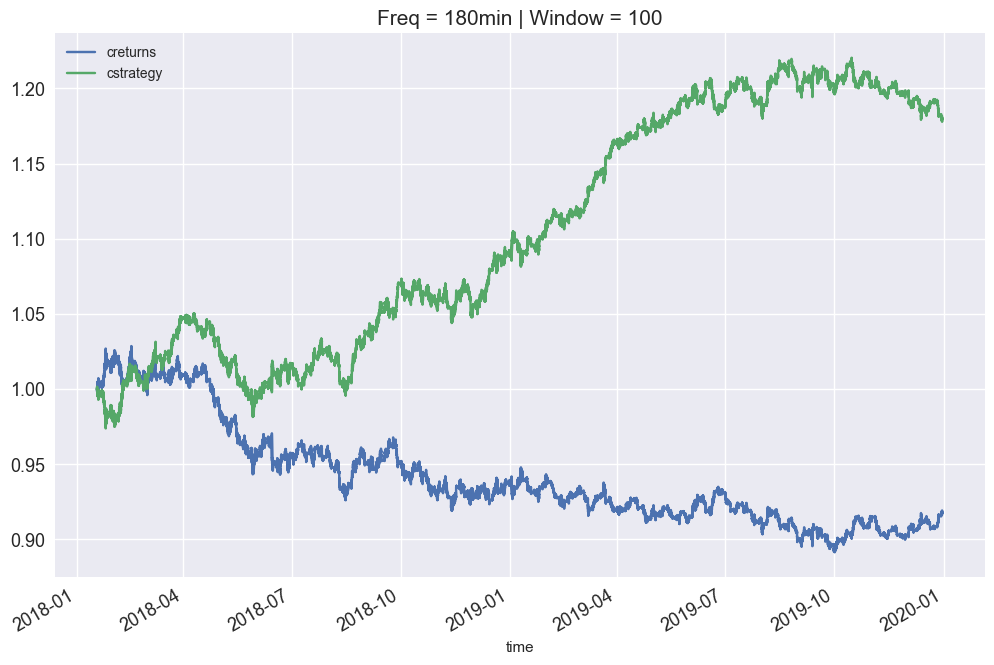

In [59]:
data[["creturns", "cstrategy"]].plot(figsize = (12, 8), fontsize = 13)
plt.title("Freq = {} | Window = {}".format(freq, window), fontsize = 15)
plt.show()

In [60]:
data.trades.value_counts()

trades
0.0    719602
2.0       230
Name: count, dtype: int64

## Updating the ConBacktester Class (Smoothing)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [3]:
# Version 4.0 (Smoothing)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
    
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().ffill()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): # added : freq
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) # new
        self.window = window
                                
        self.prepare_data(freq, window) # added: freq
        self.upsample() # new
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): # added: freq
        ''' Prepares the Data for Backtesting.
        '''
        # NEW/UPDATED
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self): # NEW!!!
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | {}: {}".format(window, self.metric, round(perf, 6))) 
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | {} vs Windows".format(self.metric), fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("{}".format(self.metric), fontsize = 15) 
            plt.show()   
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [4]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [5]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)

In [6]:
tester.data

,price,returns
time,,
2018-01-01 22:00:00,1.20071,NaN
2018-01-01 22:01:00,1.20068,-0.000025
2018-01-01 22:02:00,1.20073,0.000042
2018-01-01 22:03:00,1.20072,-0.000008
2018-01-01 22:04:00,1.20072,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


In [7]:
tester.test_strategy(freq = 180, window = 100)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 180min | WINDOW = 100
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.179787
Multiple (Buy-and-Hold):     0.91778
--------------------------------------
Out-/Underperformance:       0.262007


CAGR:                        0.088645
Annualized Mean:             0.084992
Annualized Std:              0.067755
Sharpe Ratio:                1.254397
Sortino Ratio:               1.784619
Maximum Drawdown:            0.065602
Calmar Ratio:                1.351261
Max Drawdown Duration:       156 Days
Kelly Criterion:             19.01357


In [8]:
tester.results

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0,NaN,0.0,1.000156,NaN
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090,0.0,1.000066,1.000090
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049,0.0,1.000115,1.000041
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008,0.0,1.000107,1.000049
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000,0.0,1.000107,1.000049
...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.179765


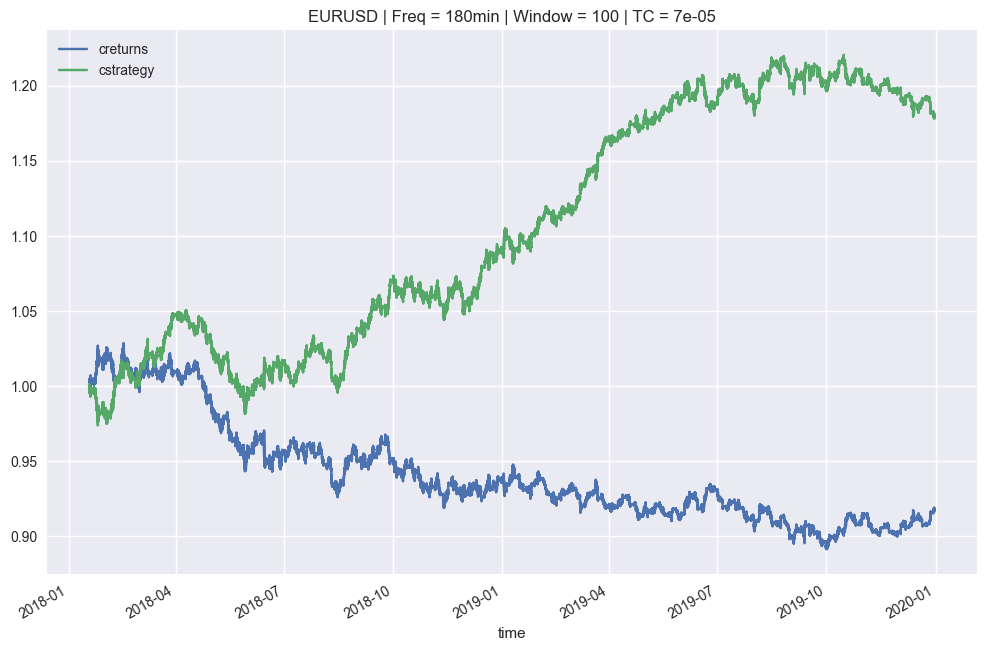

In [9]:
tester.plot_results()

## Two Parameter Optimization: Frequency and Window

In [1]:
from itertools import product
import seaborn as sns

In [10]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [11]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)

In [12]:
tester.test_strategy(freq = 180, window = 100)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 180min | WINDOW = 100
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.179787
Multiple (Buy-and-Hold):     0.91778
--------------------------------------
Out-/Underperformance:       0.262007


CAGR:                        0.088645
Annualized Mean:             0.084992
Annualized Std:              0.067755
Sharpe Ratio:                1.254397
Sortino Ratio:               1.784619
Maximum Drawdown:            0.065602
Calmar Ratio:                1.351261
Max Drawdown Duration:       156 Days
Kelly Criterion:             19.01357


In [13]:
freq_range = (51, 300, 10)
freqs = range(*freq_range)
freqs

range(51, 300, 10)

In [14]:
window_range = (51, 300, 10)
windows = range(*window_range)
windows

range(51, 300, 10)

In [15]:
len(list(windows))

25

In [16]:
combinations = list(product(freqs, windows))
combinations

[(51, 51),
 (51, 61),
 (51, 71),
 (51, 81),
 (51, 91),
 (51, 101),
 (51, 111),
 (51, 121),
 (51, 131),
 (51, 141),
 (51, 151),
 (51, 161),
 (51, 171),
 (51, 181),
 (51, 191),
 (51, 201),
 (51, 211),
 (51, 221),
 (51, 231),
 (51, 241),
 (51, 251),
 (51, 261),
 (51, 271),
 (51, 281),
 (51, 291),
 (61, 51),
 (61, 61),
 (61, 71),
 (61, 81),
 (61, 91),
 (61, 101),
 (61, 111),
 (61, 121),
 (61, 131),
 (61, 141),
 (61, 151),
 (61, 161),
 (61, 171),
 (61, 181),
 (61, 191),
 (61, 201),
 (61, 211),
 (61, 221),
 (61, 231),
 (61, 241),
 (61, 251),
 (61, 261),
 (61, 271),
 (61, 281),
 (61, 291),
 (71, 51),
 (71, 61),
 (71, 71),
 (71, 81),
 (71, 91),
 (71, 101),
 (71, 111),
 (71, 121),
 (71, 131),
 (71, 141),
 (71, 151),
 (71, 161),
 (71, 171),
 (71, 181),
 (71, 191),
 (71, 201),
 (71, 211),
 (71, 221),
 (71, 231),
 (71, 241),
 (71, 251),
 (71, 261),
 (71, 271),
 (71, 281),
 (71, 291),
 (81, 51),
 (81, 61),
 (81, 71),
 (81, 81),
 (81, 91),
 (81, 101),
 (81, 111),
 (81, 121),
 (81, 131),
 (81, 141),


In [17]:
len(combinations)

625

In [18]:
performance = []
for comb in combinations:
    tester.prepare_data(comb[0], comb[1])
    tester.upsample()
    tester.run_backtest()
    performance.append(tester.calculate_multiple(tester.results.strategy))

In [19]:
performance

[0.8449724524229771,
 0.872033949298535,
 0.8802226013036503,
 0.898820835820167,
 0.9253520989807986,
 0.8925789828221117,
 0.9171483255628511,
 0.9192192922837764,
 1.0076731272707107,
 0.9905630393300178,
 1.0365076944400544,
 1.0345108512038808,
 1.0708281598162135,
 1.054039831757945,
 1.096497373216903,
 1.092830868547967,
 1.060358940391857,
 1.1383873899780486,
 1.1494241385774424,
 1.1073759825174168,
 1.136097817184427,
 1.1501334839690098,
 1.1469755551168337,
 1.1802112119712231,
 1.080510236456242,
 0.9022289637508213,
 0.8553052110119332,
 0.8586363490826712,
 0.8955689207313713,
 0.868934205581896,
 0.922762086017166,
 1.009179528519936,
 0.9789079704345721,
 0.9933262775642752,
 1.0408259456672968,
 1.0832194562271091,
 1.0759151434999545,
 1.0976503500243884,
 1.1146756367724857,
 1.0886056405999784,
 1.1312737533098765,
 1.1415590692379989,
 1.1379770509910405,
 1.226205842857068,
 1.1667344059616183,
 1.148716110064734,
 1.1639920912255628,
 1.075404467820521,
 1.151

In [20]:
results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
results_overview

,Freq,Windows
0,51,51
1,51,61
2,51,71
3,51,81
4,51,91
...,...,...
620,291,251
621,291,261
622,291,271
623,291,281


In [21]:
results_overview["Performance"] = performance
results_overview

,Freq,Windows,Performance
0,51,51,0.844972
1,51,61,0.872034
2,51,71,0.880223
3,51,81,0.898821
4,51,91,0.925352
...,...,...,...
620,291,251,1.024589
621,291,261,1.077344
622,291,271,1.031718
623,291,281,1.004028


In [22]:
results_overview.nlargest(10, "Performance")

,Freq,Windows,Performance
380,201,101,1.412225
258,151,131,1.347173
307,171,121,1.324477
163,111,181,1.323788
404,211,91,1.321807
331,181,111,1.318309
602,291,71,1.313675
210,131,151,1.306025
552,271,71,1.300831
478,241,81,1.294582


In [23]:
matrix = results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
matrix

Windows,51,61,71,81,91,101,111,121,131,141,...,201,211,221,231,241,251,261,271,281,291
Freq,,,,,,,,,,,,,,,,,,,,,
51,0.844972,0.872034,0.880223,0.898821,0.925352,0.892579,0.917148,0.919219,1.007673,0.990563,...,1.092831,1.060359,1.138387,1.149424,1.107376,1.136098,1.150133,1.146976,1.180211,1.080510
61,0.902229,0.855305,0.858636,0.895569,0.868934,0.922762,1.009180,0.978908,0.993326,1.040826,...,1.131274,1.141559,1.137977,1.226206,1.166734,1.148716,1.163992,1.075404,1.151432,1.210260
71,0.865919,0.848310,0.874528,0.913028,1.005389,0.999504,1.035826,1.066681,1.071023,1.069469,...,1.236469,1.090078,1.115203,1.163364,1.198240,1.220814,1.207513,1.287173,1.279803,1.198805
81,0.930111,0.926289,0.860536,0.980358,1.019838,1.072307,1.026823,1.063753,1.182637,1.145699,...,1.235161,1.145360,1.183735,1.275997,1.280948,1.207929,1.197380,1.093180,1.084607,1.093715
91,0.923512,0.913409,0.984759,1.023579,1.024948,1.050117,1.049250,1.056253,1.142077,1.164269,...,1.272632,1.286787,1.286978,1.176039,1.074496,1.059430,1.128938,1.072637,1.042283,1.064400
101,0.884209,0.941890,0.976067,1.045988,1.109496,1.097421,1.158496,1.121585,1.188381,1.218342,...,1.258031,1.157832,1.031798,1.061325,1.089094,1.098221,1.039237,1.109282,1.072385,1.105348
111,0.945783,1.040548,1.019063,1.072413,1.046363,1.146547,1.130198,1.135466,1.160401,1.211146,...,1.049558,1.014296,1.085832,0.993980,1.053268,1.139878,1.078216,1.117446,1.019094,1.112717
121,0.970074,1.055137,1.055812,1.153381,1.169508,1.143472,1.206365,1.160596,1.183597,1.225958,...,1.089102,1.056188,1.069110,1.133003,1.069293,1.066805,1.042222,1.096162,1.073244,1.163045
131,1.028649,1.054093,1.111513,1.111078,1.177803,1.215104,1.167226,1.178808,1.204473,1.262861,...,1.058696,1.092601,1.041818,1.083368,1.045092,1.150146,1.079286,1.123159,1.070694,1.105920


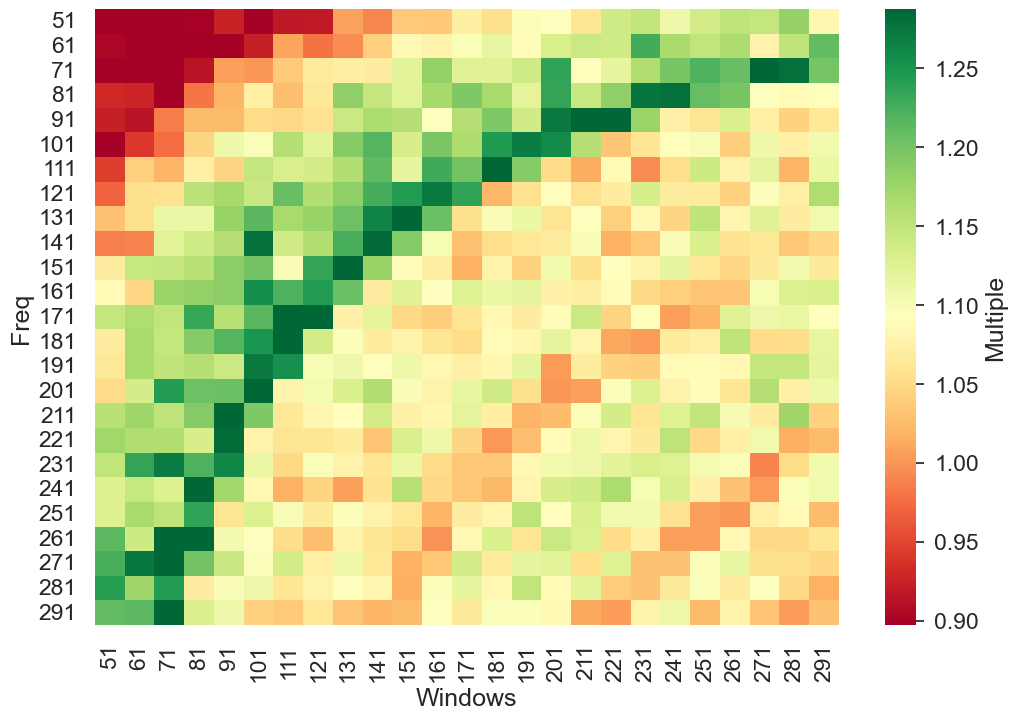

In [24]:
plt.figure(figsize=(12,8))
sns.set_theme(font_scale=1.5)
sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "Multiple"})
plt.show()

## Updating the ConBacktester Class (Two Parameter Optimization)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from itertools import product
import seaborn as sns

In [5]:
# Version 4.1 (Smoothing and Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().ffill()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): # added: freq_range
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  # NEW!!!
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) # NEW!!!
        
        performance = []
        for comb in combinations: # ADJ!!!
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] # NEW!!!
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) # added: freq 
        self.test_strategy(freq, window) # added: freq
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: # NEW!!!
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [2]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [6]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [7]:
tester.optimize_strategy(freq_range = (51, 300, 5), window_range = (51, 300, 5), metric = "Multiple")

Frequency: 201 | Windows: 101 | Multiple: 1.412225
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126


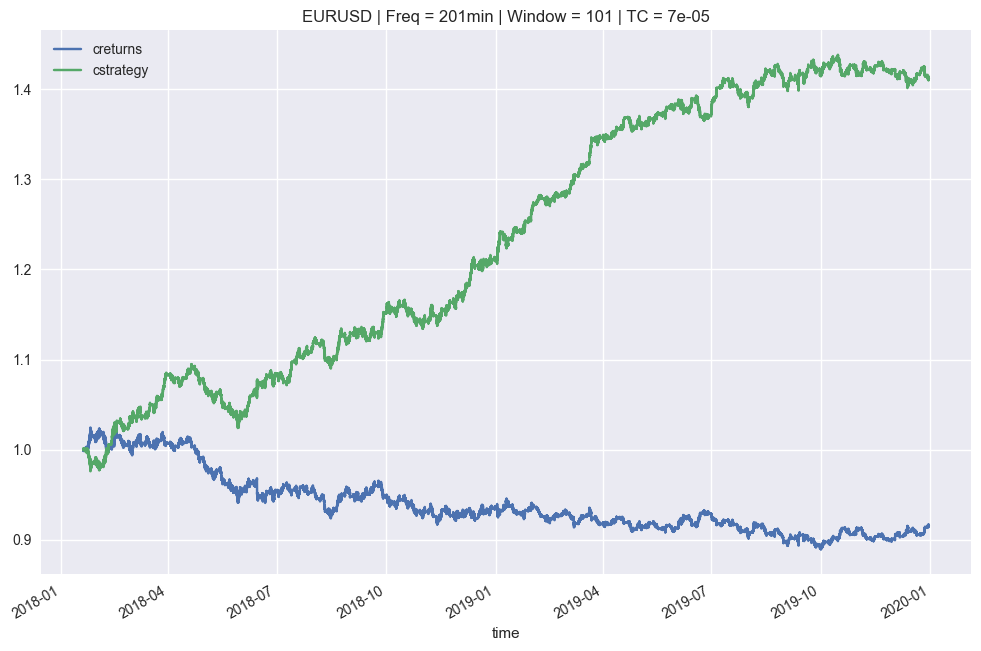

In [8]:
tester.plot_results()

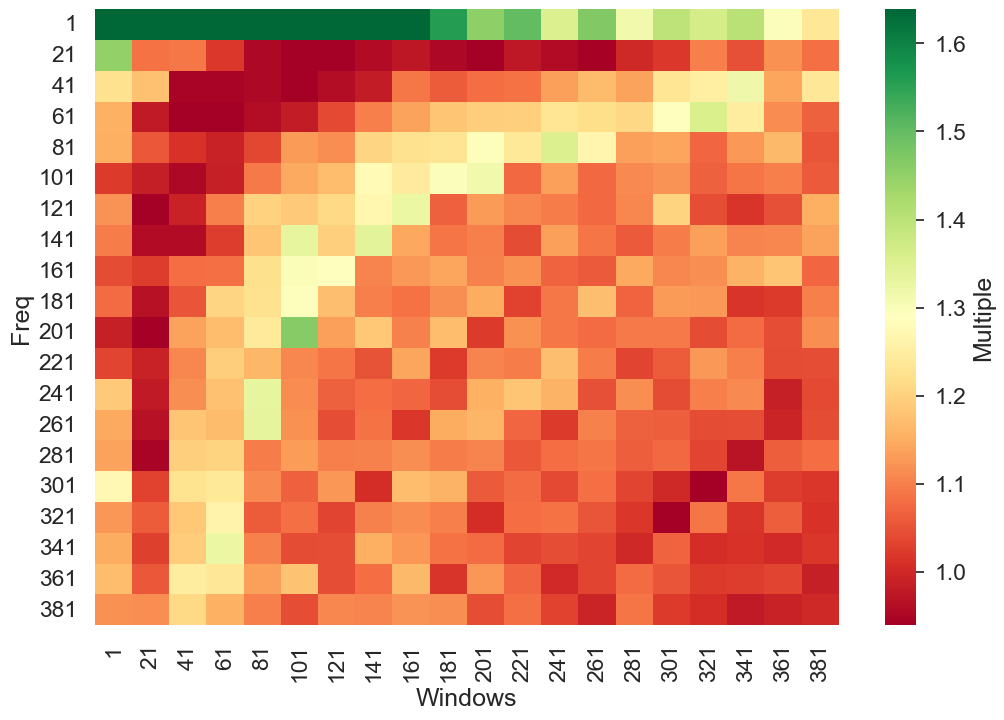

In [18]:
tester.visualize_many()

In [10]:
tester.results_overview.nlargest(10, "Performance")

,Freq,Windows,Performance
1510,201,101,1.412225
1016,151,131,1.347173
1609,211,96,1.346912
967,146,136,1.346191
577,106,186,1.344446
772,126,161,1.336674
1411,191,106,1.333248
1263,176,116,1.333048
1857,236,86,1.330502
1213,171,116,1.325144


In [11]:
tester.optimize_strategy((180, 181, 1), (80, 140, 1), metric = "Multiple") # best strategy with freq = 180

Frequency: 180 | Windows: 112 | Multiple: 1.320054
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 180min | WINDOW = 112
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.320054
Multiple (Buy-and-Hold):     0.915725
--------------------------------------
Out-/Underperformance:       0.404329


CAGR:                        0.153551
Annualized Mean:             0.143171
Annualized Std:              0.067665
Sharpe Ratio:                2.115871
Sortino Ratio:               3.017504
Maximum Drawdown:            0.065399
Calmar Ratio:                2.347908
Max Drawdown Duration:       91 Days
Kelly Criterion:             31.769389


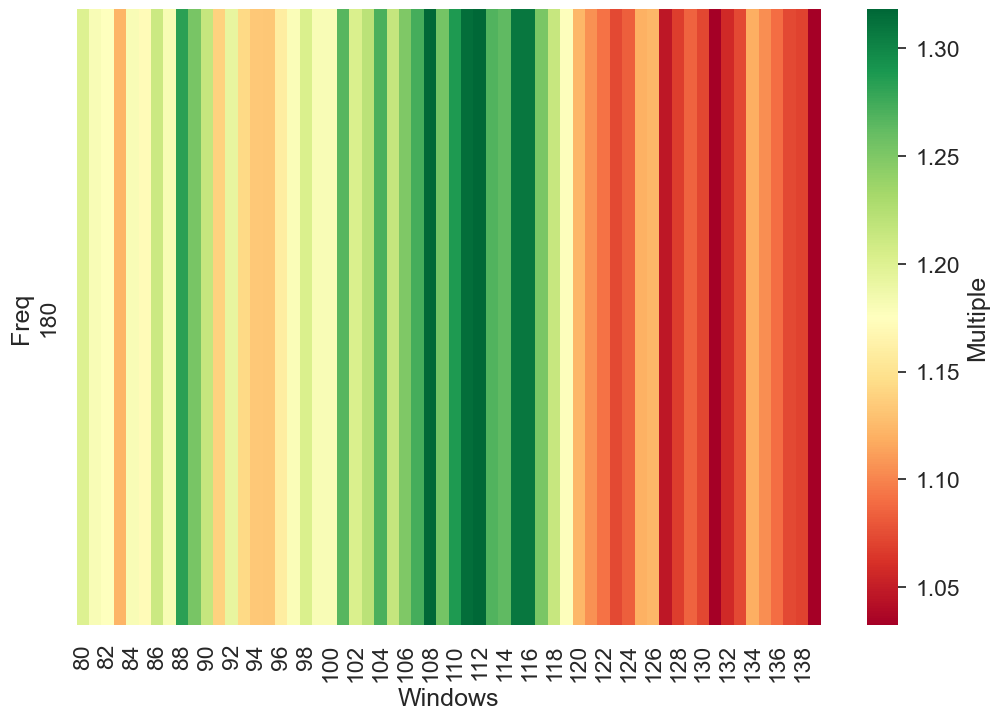

In [12]:
tester.visualize_many()

__Conclusion__: there doesn´t exist THE "best frequency". It´s all about the __right combination frequency/window__.

In [13]:
ptc = 0

In [14]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [15]:
tester.optimize_strategy((1, 400, 20), (1, 400, 20), metric = "Multiple")

Frequency: 1 | Windows: 1 | Multiple: 3.499104
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 1min | WINDOW = 1
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         3.499104
Multiple (Buy-and-Hold):     0.932915
--------------------------------------
Out-/Underperformance:       2.566189


CAGR:                        0.874617
Annualized Mean:             0.628406
Annualized Std:              0.066349
Sharpe Ratio:                9.471283
Sortino Ratio:               13.398433
Maximum Drawdown:            0.039522
Calmar Ratio:                22.129769
Max Drawdown Duration:       41 Days
Kelly Criterion:             143.252176


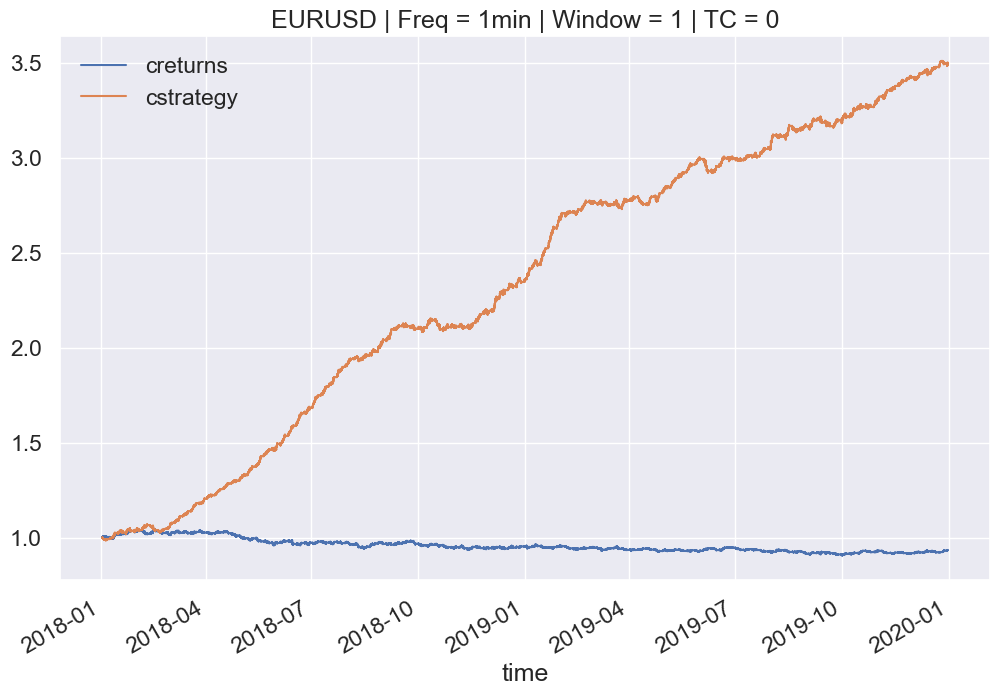

In [16]:
tester.plot_results()

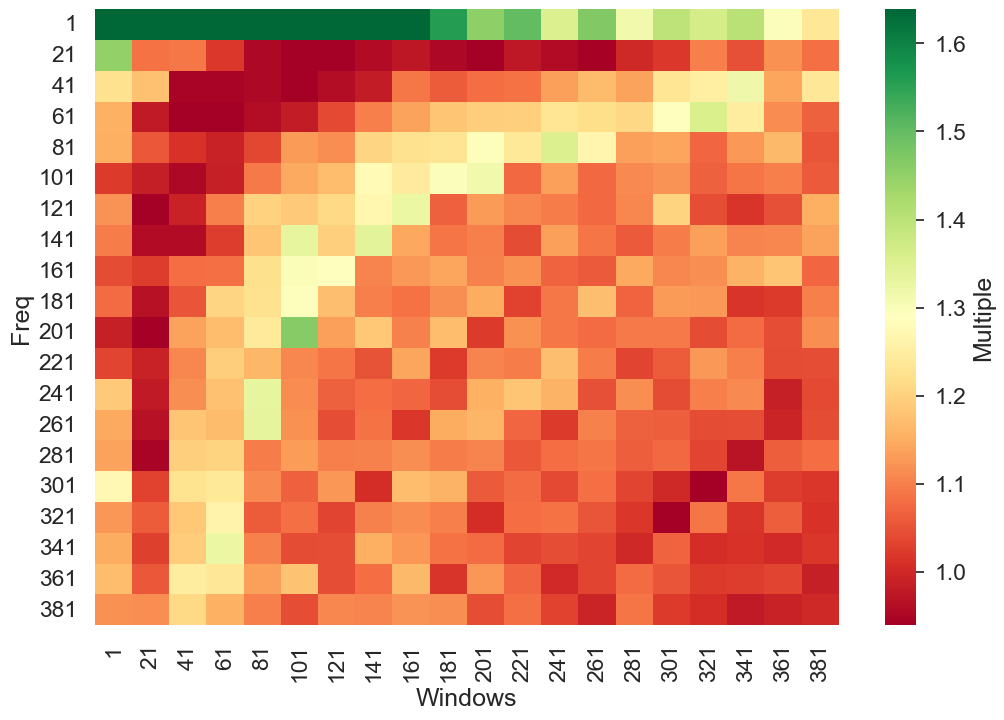

In [17]:
tester.visualize_many()

__Conclusion__: 
- __Trading Costs won´t allow us to work with higher frequencies__ and to exploit short term volatility. 
- Additional __costs are way higher__ than additional benefits.